**PROBLEM STATEMENT:**

Olist, a Brazilian ecommerce marketplace, is experiencing concerns from sellers regarding delayed deliveries and decreased conversion rates. The company aims to identify friction points in the purchase-to-delivery funnel and conduct experiments to improve seller performance and customer experience. The objective is to diagnose these issues, propose data-backed improvements and offer useful insights through dashboards and experiments. 

**TASK 3: Customer Segmentation and Value Analysis**

**Business Objective:**
Olist aims to identify its most valuable customers by analyzing their total spend, order frequency, and behavioral patterns by applying the following strategic business logic:

Total Spend Analysis
→ Measure the cumulative revenue from each customer (price + freight) to understand their monetary contribution.

Order Frequency
→ Identify repeat customers and assess how often they purchase, indicating long-term value and brand engagement.

RFM Segmentation
→ Use Recency, Frequency, and Monetary scores to classify customers into actionable groups like:

1. Top Customers
2. Loyal Customers
3. Recent Buyers
4. Frequent Buyers
5. At-Risk



In [3]:
import pandas as pd, numpy as np
from datetime import datetime

In [4]:
df=pd.read_csv('customers_final.csv')

First we will group by customer unique id(which informs us about total number of purchases per customer) to find out key insights which will aid us with our value analysis.

In [6]:

rfm = df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': 'max',               
    'order_id': pd.Series.nunique,                   
    'payment_value': 'sum',
    'review_score': 'mean'
}).reset_index()

In [7]:
#Rename the columns for more clarity
rfm.rename(columns={
    'order_purchase_timestamp': 'last_order_date',
    'order_id': 'order_count',
    'review_score': 'avg_review_score',
    'payment_value': 'total_spend'
}, inplace=True)

In [8]:
rfm.head()

,customer_unique_id,last_order_date,order_count,total_spend,avg_review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,141.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,27.19,4.0
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,86.22,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,43.62,4.0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,196.89,5.0


In [9]:
rfm['last_order_date'] = pd.to_datetime(rfm['last_order_date'])

First we will find a reference date (latest order date), against which we will be checking all customers latest order date to calculate recency (how recent was the order purchased)

In [10]:
reference_date = rfm['last_order_date'].max() + pd.Timedelta(days=1)
rfm['recency'] = (reference_date - rfm['last_order_date']).dt.days

Now, we will find out R, F, and M score which are crucial in finding a customers overall RFM score.

In [11]:
rfm['R_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_score'] = pd.qcut(rfm['order_count'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_score'] = pd.qcut(rfm['total_spend'], 5, labels=[1, 2, 3, 4, 5])

In [33]:
#we will now concatenate the score to get our RFM value.
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

This function aids in categorising customers in different segments 

In [13]:
def segment(r, f, m):
    if r >= 4 and f >= 4 and m >= 4:
        return 'Top Customers'
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Loyal Customers'
    elif m >= 4:
        return 'Big Spenders'
    elif r >= 4:
        return 'Recent Buyers'
    elif f >= 4:
        return 'Frequent Buyers'
    else:
        return 'At Risk'

rfm['Segment'] = rfm.apply(lambda x: segment(int(x['R_score']), int(x['F_score']), int(x['M_score'])), axis=1)

In [14]:
rfm.sample(5)

,customer_unique_id,last_order_date,order_count,total_spend,avg_review_score,recency,R_score,F_score,M_score,RFM_Score,Segment
75555,d3147419ec94a159d6dca192bec3fc53,2018-03-01 12:02:48,1,133.76,5.0,182,3,5,3,353,Loyal Customers
18751,34471a8e1a3d5425d255efa7d4b06220,2018-03-03 22:22:38,1,89.88,5.0,179,3,1,3,313,At Risk
74145,cf587ddafc6594d449e7c643883a7aab,2017-04-27 22:01:14,1,74.49,1.0,489,1,4,2,142,Frequent Buyers
80524,e10bfd6b9b21521ec97f6cb2dc737eef,2018-05-18 17:45:22,1,128.55,4.0,103,4,5,3,453,Loyal Customers
37946,69ebe4121049936c63874c340f4c96af,2017-11-24 23:22:30,1,130.46,1.0,278,2,3,3,233,At Risk


We have around 3k customers who have made purchase more than once.

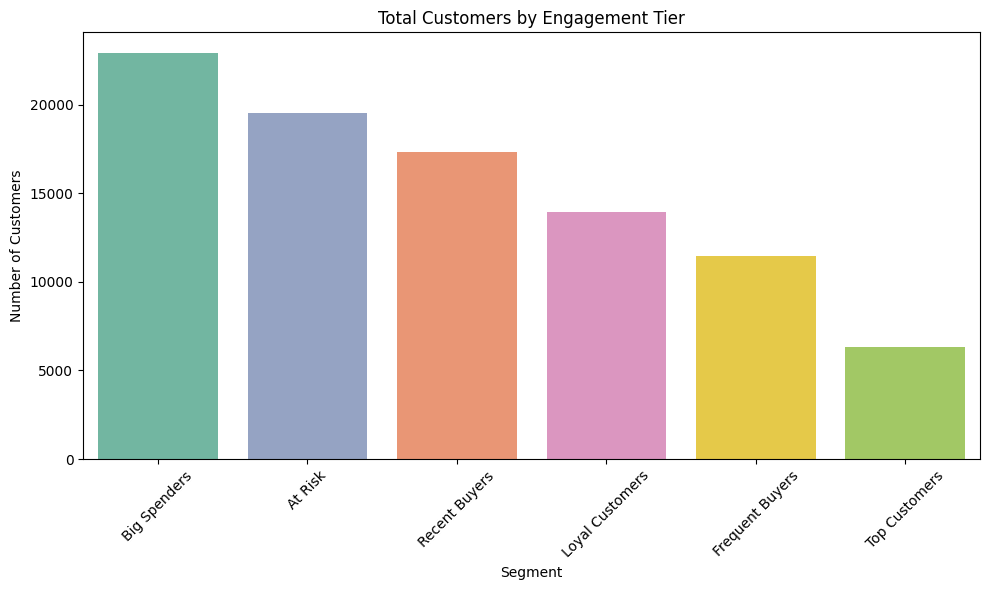

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, hue= 'Segment', palette='Set2')
plt.title('Total Customers by Engagement Tier')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


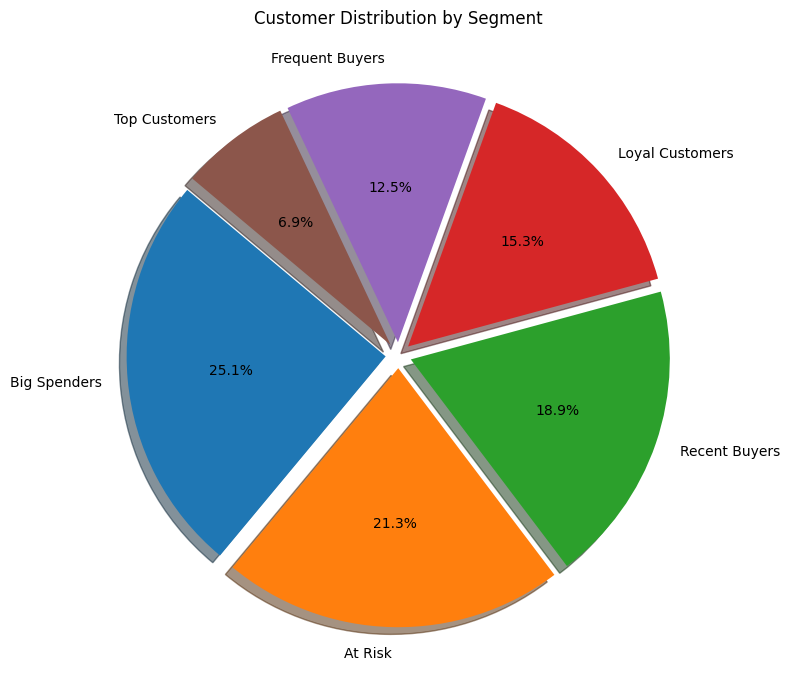

In [36]:
#We can also plot a pie chart to see the percent distribution of each segment.
segment_counts = rfm['Segment'].value_counts()

# Plot 3D-like pie (Note: True 3D pies are rare in matplotlib — this is a regular pie with some formatting)
plt.figure(figsize=(8,8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, explode=[0.05]*len(segment_counts), shadow=True)
plt.title('Customer Distribution by Segment')
plt.tight_layout()
plt.show()


- Big Spenders make up the largest segment, indicating strong revenue potential. Olist should consider offering exclusive offers and loyalty programs to further nurture these high-value customers. 
- At Risk customers also occupy a subsantial share, which highlights the importance of retention strategies such as personalized discounts and targeted campaigns.
- Top Customers and Frequent Buyers hold relatively smaller share, suggesting room to grow loyal, high-frequency purchasers. The company should focus on targeted upselling to convert them into loyal customers. 
